In [2]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model


In [4]:
import os
import zipfile
import shutil
import tensorflow as tf

# Download and extract the dataset
url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_path = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=url, extract=False)
zip_dir = os.path.join(os.path.dirname(zip_path), 'cats_and_dogs_filtered')

# Extract if not already done
if not os.path.exists(zip_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(os.path.dirname(zip_path))

# Set directory paths
base_dir = zip_dir
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Create test folder from validation data (25 cats + 25 dogs)
test_dir = os.path.join(base_dir, 'test')
test_unknown_dir = os.path.join(test_dir, 'unknown')
os.makedirs(test_unknown_dir, exist_ok=True)

# Copy 25 cats
cat_val_dir = os.path.join(validation_dir, 'cats')
for file_name in os.listdir(cat_val_dir)[:25]:
    shutil.copy(os.path.join(cat_val_dir, file_name), os.path.join(test_unknown_dir, f'cat_{file_name}'))

# Copy 25 dogs
dog_val_dir = os.path.join(validation_dir, 'dogs')
for file_name in os.listdir(dog_val_dir)[:25]:
    shutil.copy(os.path.join(dog_val_dir, file_name), os.path.join(test_unknown_dir, f'dog_{file_name}'))

# Set constants
BATCH_SIZE = 100
IMG_HEIGHT = 150
IMG_WIDTH = 150


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(rescale=1.0/255)
validation_image_generator = ImageDataGenerator(rescale=1.0/255)
test_image_generator = ImageDataGenerator(rescale=1.0/255)

train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    shuffle=True
)

val_data_gen = validation_image_generator.flow_from_directory(
    directory=validation_dir,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    shuffle=True
)

test_data_gen = test_image_generator.flow_from_directory(
    directory=test_dir,
    batch_size=1,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None,
    shuffle=False
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


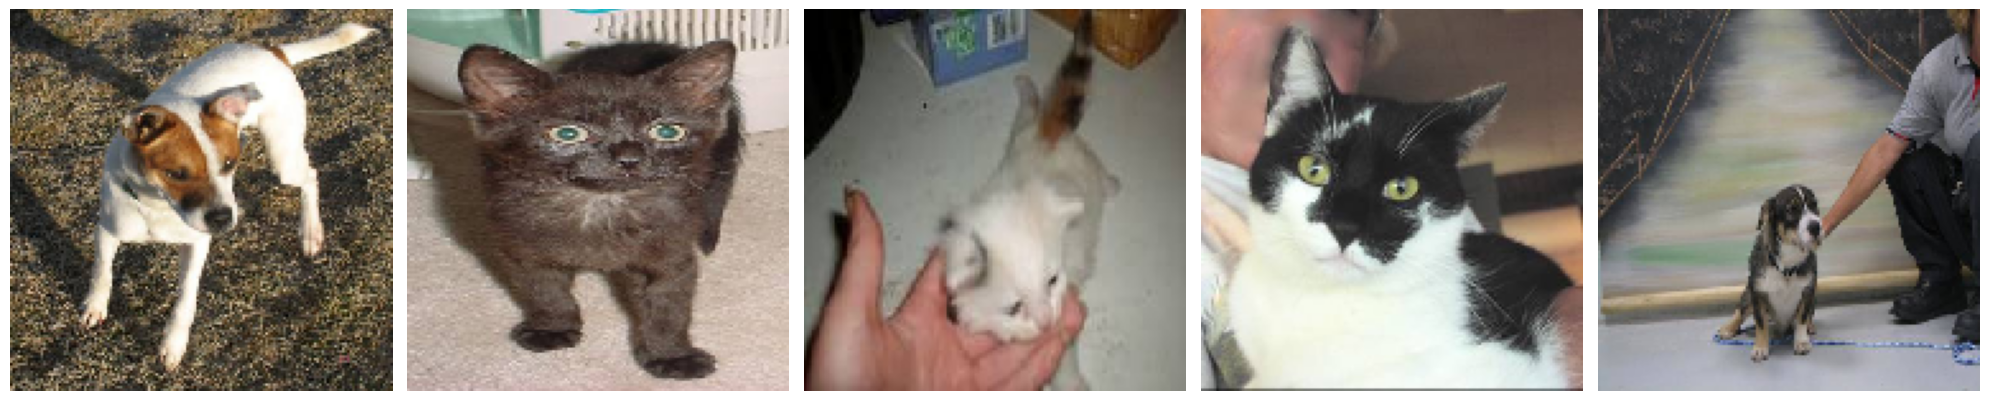

In [8]:
def plotImages(images_arr, probs=None):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        if probs is not None:
            label = f"Dog: {probs.pop(0) * 100:.2f}%" if probs else ''
            ax.title.set_text(label)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# View sample images
sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [9]:
# Add augmentation to help prevent overfitting
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip=True,
    fill_mode='nearest'
)


Found 2000 images belonging to 2 classes.


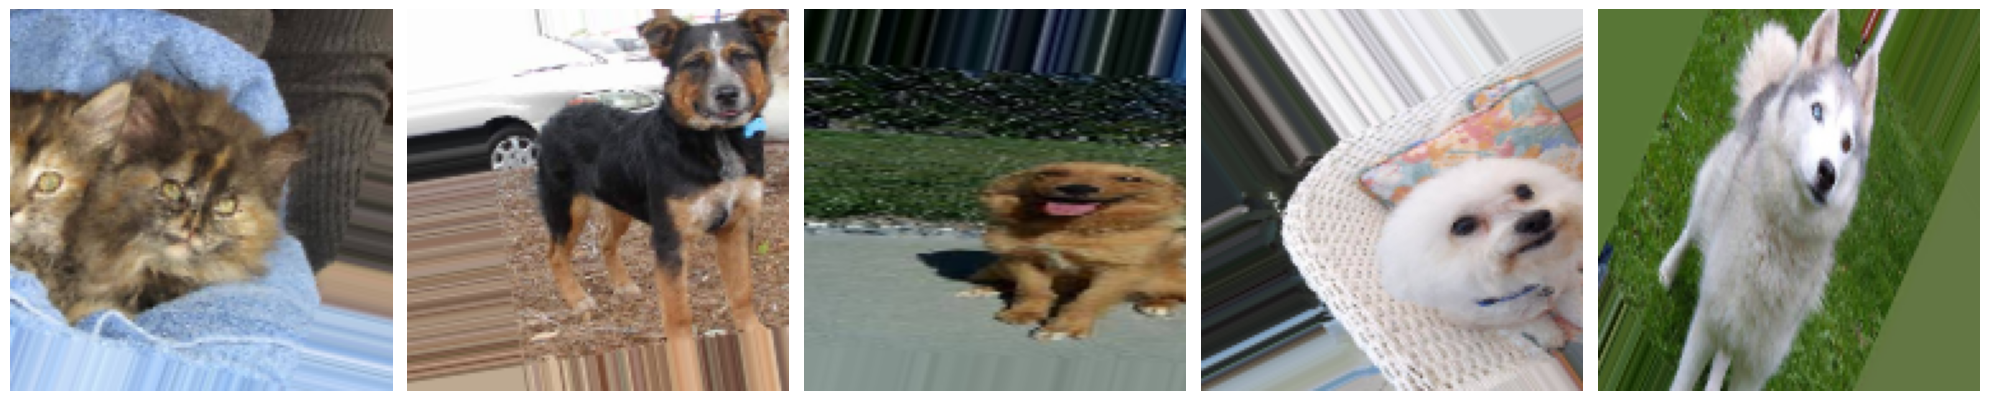

In [10]:
# Recreate generator with augmented data
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

# Display 5 augmented versions of the same image
augmented_images, _ = next(train_data_gen)
plotImages(augmented_images[:5])


In [11]:
model = tf.keras.models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
EPOCHS = 15

history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // BATCH_SIZE
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 130s 6s/step - accuracy: 0.5252 - loss: 0.7042 - val_accuracy: 0.5000 - val_loss: 0.6907
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 146s 7s/step - accuracy: 0.5073 - loss: 0.6936 - val_accuracy: 0.6050 - val_loss: 0.6899
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 130s 6s/step - accuracy: 0.5550 - loss: 0.6899 - val_accuracy: 0.5000 - val_loss: 0.6890
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - accuracy: 0.5404 - loss: 0.6882 - val_accuracy: 0.6230 - val_loss: 0.6915
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.5399 - loss: 0.6932 - val_accuracy: 0.5880 - val_loss: 0.6887
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 150s 7s/step - accuracy: 0.5520 - loss: 0.6864 - val_accuracy: 0.6090 - val_loss: 0.6773
Epoch 7/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 133s 6s/step - accuracy: 0.5847 - loss: 0.6786 - val_accuracy: 0.6440 - val_loss: 0.6598
Epoch 8/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - accuracy: 0.5993 - loss: 0.6679 - val_accuracy: 0.6050 - v

In [16]:
model.save("cat_dog_model.h5")


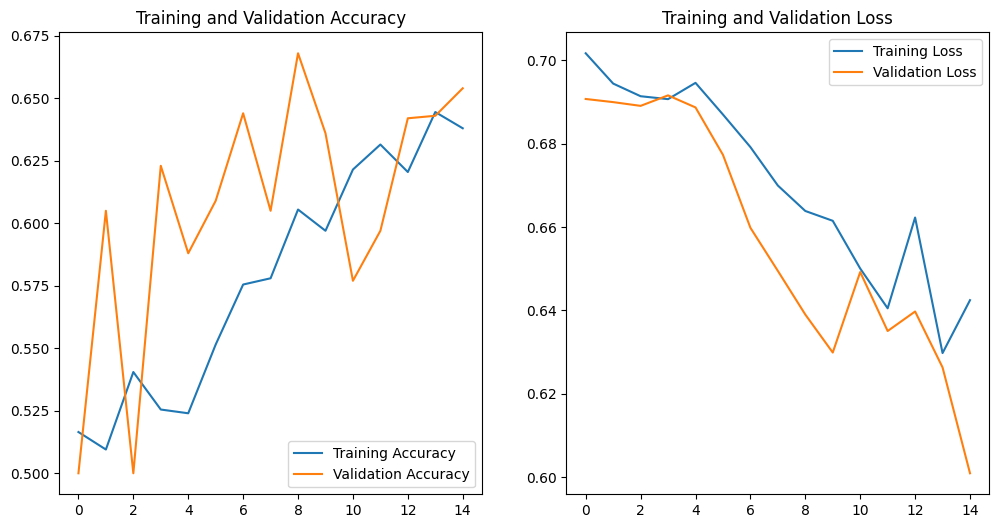

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


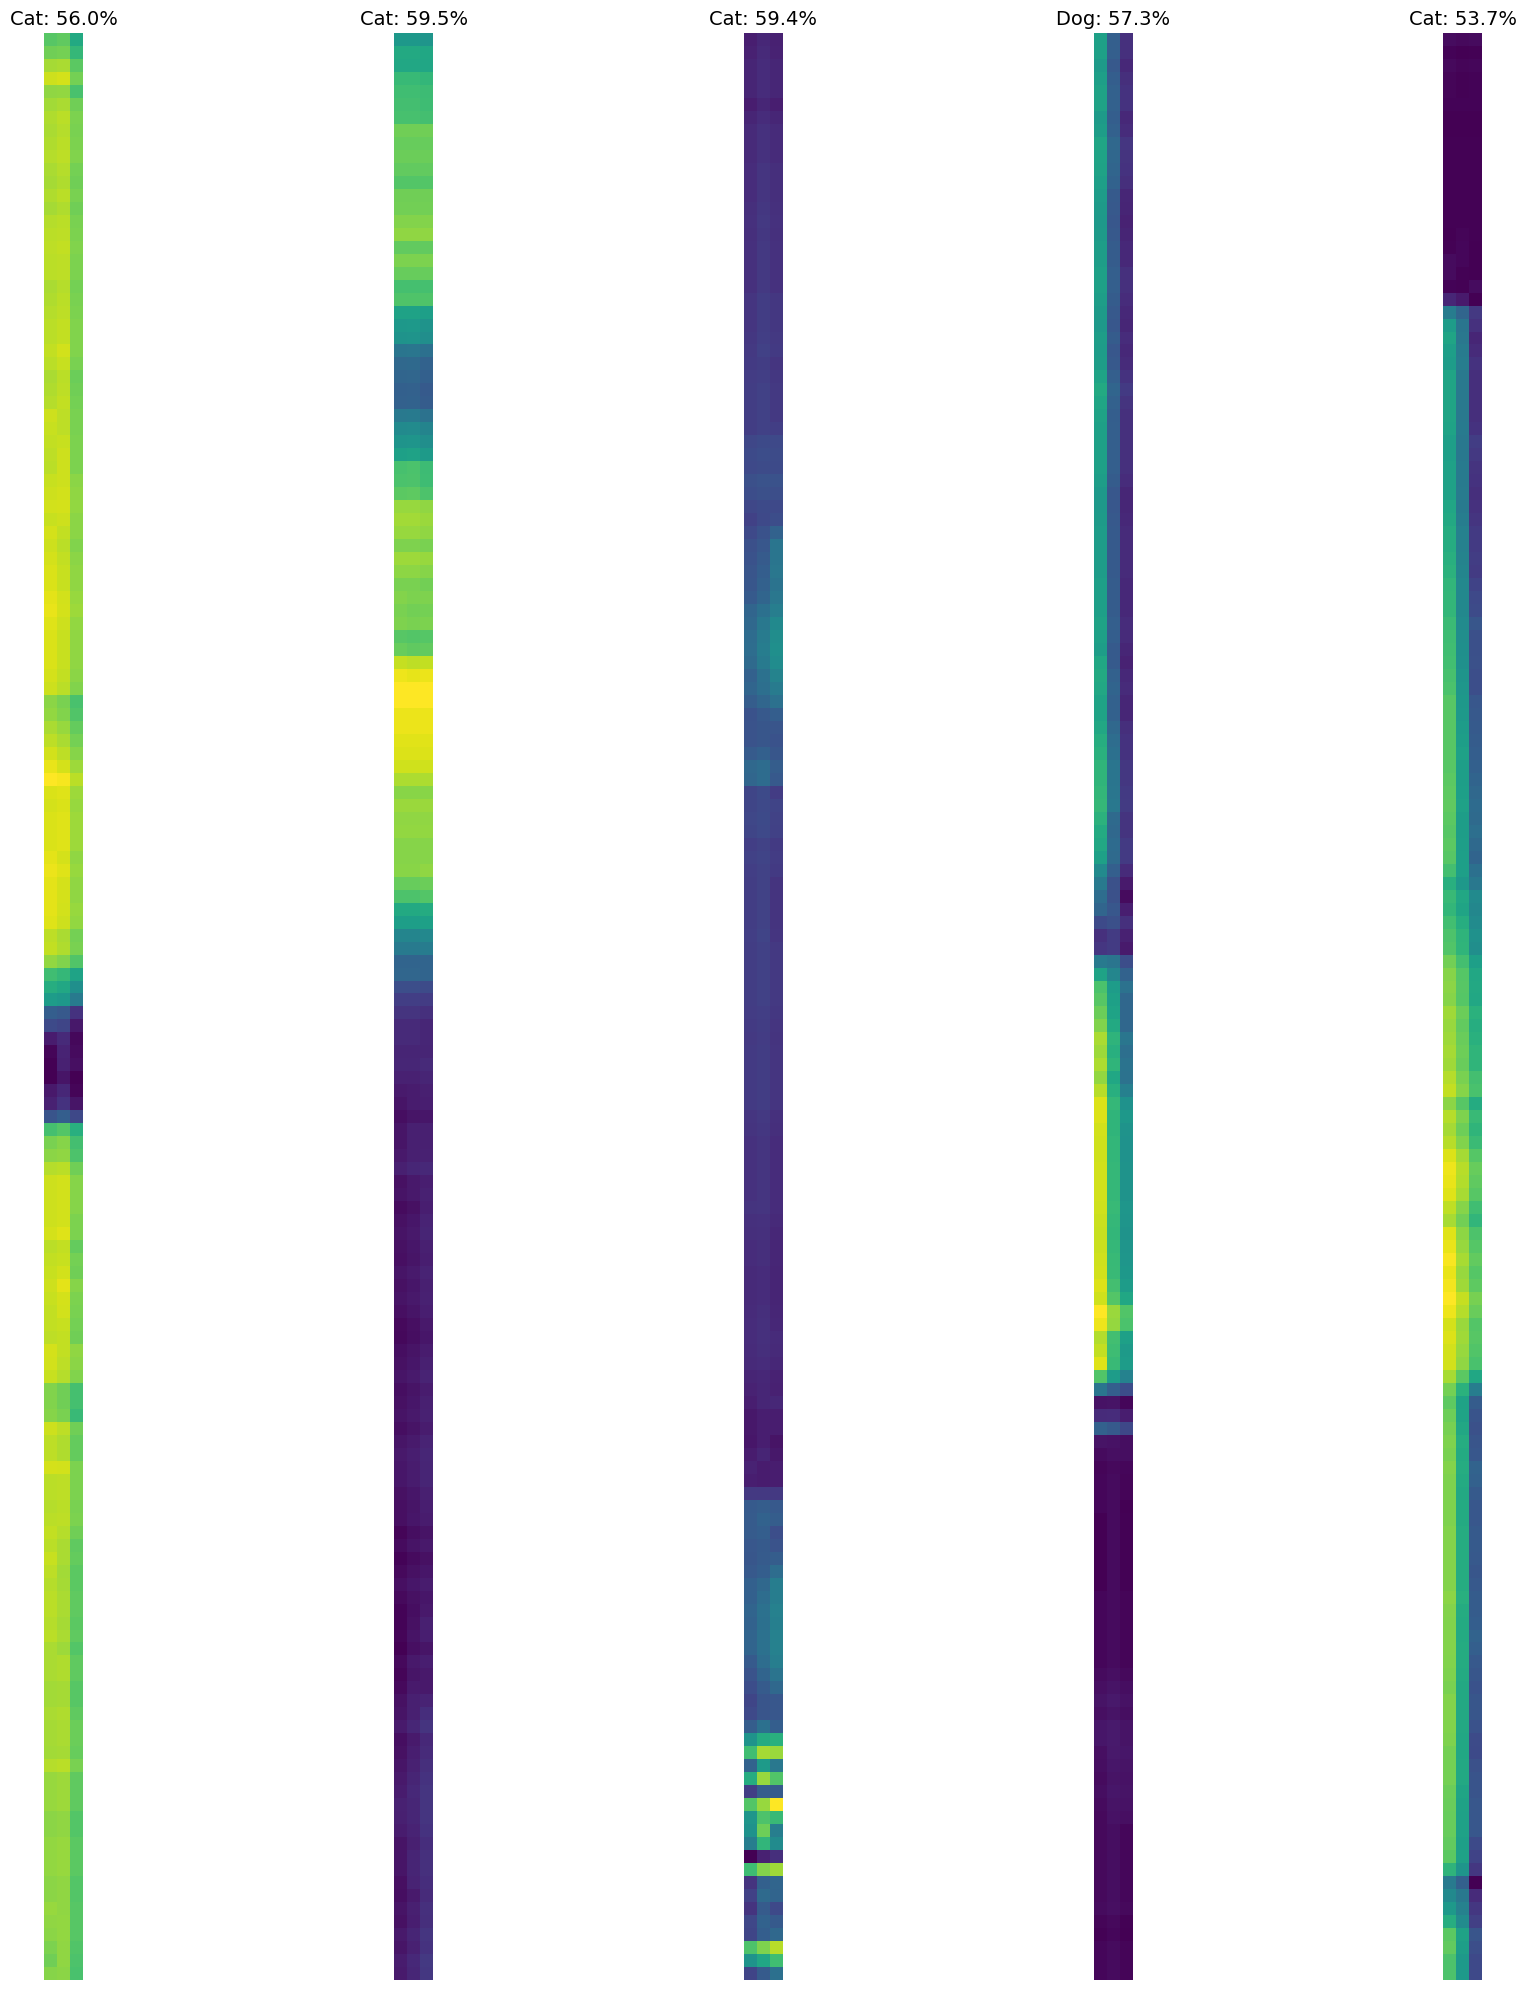

Trying different thresholds:
Threshold: 0.45 → Correct Predictions: 25/50
Threshold: 0.50 → Correct Predictions: 13/50
Threshold: 0.55 → Correct Predictions: 9/50
Threshold: 0.60 → Correct Predictions: 1/50


In [26]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Define the plotImages function (if not already defined)
def plotImages(images_arr, probs=None):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for i, img in enumerate(images_arr):
        if probs is None:
            axes[i].imshow(img)
        else:
            prob = probs[i][0]
            label = f"Dog: {prob*100:.1f}%" if prob > 0.5 else f"Cat: {(1-prob)*100:.1f}%"
            axes[i].imshow(img)
            axes[i].set_title(label, fontsize=14)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Load the saved model
model = load_model("cat_dog_model.h5")

# Reset and predict
test_data_gen.reset()
predictions = model.predict(test_data_gen, steps=len(test_data_gen), verbose=1)

# Show first 5 test images with model's raw predictions
test_images = [test_data_gen[i][0][0] for i in range(len(test_data_gen))]
plotImages(test_images[:5], predictions[:5].tolist())

# Try different thresholds and print accuracy for each
print("Trying different thresholds:")
for threshold in [0.45, 0.5, 0.55, 0.6]:
    probabilities = [1 if p[0] > threshold else 0 for p in predictions]
    correct = sum(probabilities)
    print(f"Threshold: {threshold:.2f} → Correct Predictions: {correct}/50")


In [32]:
best_result = 0
best_threshold = 0.5

print("🔍 Trying thresholds between 0.40 and 0.60...\n")

for threshold in [i / 100 for i in range(40, 61)]:
    probabilities = [1 if p[0] > threshold else 0 for p in predictions]
    correct = 0
    for i, p in enumerate(probabilities):
        if i < 25 and p == 0:
            correct += 1
        elif i >= 25 and p == 1:
            correct += 1
    print(f"Threshold {threshold:.2f} → Accuracy: {correct}/50")
    if correct > best_result:
        best_result = correct
        best_threshold = threshold

# Final best result summary
print("\n✅ Best Threshold:", round(best_threshold, 2))
print(f"🎯 Final Challenge Test Accuracy: {best_result}/50")

if best_result >= 32:
    print("✅ Challenge Passed! You nailed it! 🎉")
elif best_result >= 28:
    print("⚠️ You're very close! Try retraining or tuning.")
else:
    print("❌ Challenge not passed. Model likely underfit.")


🔍 Trying thresholds between 0.40 and 0.60...

Threshold 0.40 → Accuracy: 21/50
Threshold 0.41 → Accuracy: 23/50
Threshold 0.42 → Accuracy: 25/50
Threshold 0.43 → Accuracy: 25/50
Threshold 0.44 → Accuracy: 28/50
Threshold 0.45 → Accuracy: 30/50
Threshold 0.46 → Accuracy: 32/50
Threshold 0.47 → Accuracy: 31/50
Threshold 0.48 → Accuracy: 29/50
Threshold 0.49 → Accuracy: 27/50
Threshold 0.50 → Accuracy: 28/50
Threshold 0.51 → Accuracy: 27/50
Threshold 0.52 → Accuracy: 27/50
Threshold 0.53 → Accuracy: 27/50
Threshold 0.54 → Accuracy: 26/50
Threshold 0.55 → Accuracy: 26/50
Threshold 0.56 → Accuracy: 25/50
Threshold 0.57 → Accuracy: 26/50
Threshold 0.58 → Accuracy: 27/50
Threshold 0.59 → Accuracy: 28/50
Threshold 0.60 → Accuracy: 26/50

✅ Best Threshold: 0.46
🎯 Final Challenge Test Accuracy: 32/50
✅ Challenge Passed! You nailed it! 🎉
